Data Loaded!


/usr/local/lib/python3.10/dist-packages/torchmetrics/utilities/prints.py:62: FutureWarning: Importing `StructuralSimilarityIndexMeasure` from `torchmetrics` was deprecated and will be removed in 2.0. Import `StructuralSimilarityIndexMeasure` from `torchmetrics.image` instead.
  _future_warning(
Epoch 1/20: 100%|██████████| 1804/1804 [05:57<00:00,  5.05it/s]


  >> Epoch 1 finished | Mean Loss = 1.5088


Epoch 2/20: 100%|██████████| 1804/1804 [04:58<00:00,  6.05it/s]


  >> Epoch 2 finished | Mean Loss = 0.6439


Epoch 3/20: 100%|██████████| 1804/1804 [04:56<00:00,  6.09it/s]


  >> Epoch 3 finished | Mean Loss = 0.6338


Epoch 4/20: 100%|██████████| 1804/1804 [04:53<00:00,  6.15it/s]


  >> Epoch 4 finished | Mean Loss = 0.6271


Epoch 5/20: 100%|██████████| 1804/1804 [04:54<00:00,  6.13it/s]


  >> Epoch 5 finished | Mean Loss = 0.6204


Epoch 6/20: 100%|██████████| 1804/1804 [04:52<00:00,  6.17it/s]


  >> Epoch 6 finished | Mean Loss = 0.6100


Epoch 7/20: 100%|██████████| 1804/1804 [04:57<00:00,  6.06it/s]


  >> Epoch 7 finished | Mean Loss = 0.6421


Epoch 8/20: 100%|██████████| 1804/1804 [04:55<00:00,  6.11it/s]


  >> Epoch 8 finished | Mean Loss = 0.6062


Epoch 9/20: 100%|██████████| 1804/1804 [04:56<00:00,  6.08it/s]


  >> Epoch 9 finished | Mean Loss = 0.6034


Epoch 10/20: 100%|██████████| 1804/1804 [04:58<00:00,  6.04it/s]


  >> Epoch 10 finished | Mean Loss = 0.6196


Epoch 11/20: 100%|██████████| 1804/1804 [04:57<00:00,  6.06it/s]


  >> Epoch 11 finished | Mean Loss = 0.6012


Epoch 12/20: 100%|██████████| 1804/1804 [04:56<00:00,  6.09it/s]


  >> Epoch 12 finished | Mean Loss = 0.5998


Epoch 13/20: 100%|██████████| 1804/1804 [04:55<00:00,  6.11it/s]


  >> Epoch 13 finished | Mean Loss = 0.5985


Epoch 14/20: 100%|██████████| 1804/1804 [04:56<00:00,  6.09it/s]


  >> Epoch 14 finished | Mean Loss = 0.5974


Epoch 15/20: 100%|██████████| 1804/1804 [04:55<00:00,  6.10it/s]


  >> Epoch 15 finished | Mean Loss = 0.6491


Epoch 16/20: 100%|██████████| 1804/1804 [04:55<00:00,  6.11it/s]


  >> Epoch 16 finished | Mean Loss = 0.5952


Epoch 17/20: 100%|██████████| 1804/1804 [04:54<00:00,  6.12it/s]


  >> Epoch 17 finished | Mean Loss = 0.5943


Epoch 18/20: 100%|██████████| 1804/1804 [04:57<00:00,  6.06it/s]


  >> Epoch 18 finished | Mean Loss = 0.5936


Epoch 19/20: 100%|██████████| 1804/1804 [04:57<00:00,  6.07it/s]


  >> Epoch 19 finished | Mean Loss = 0.5937


Epoch 20/20: 100%|██████████| 1804/1804 [04:54<00:00,  6.13it/s]


  >> Epoch 20 finished | Mean Loss = 0.5922
Model Trained!


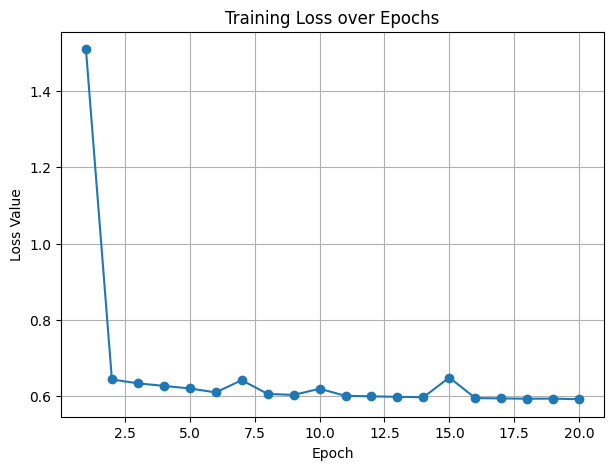

Model saved to tri_vae_model_final.pth.


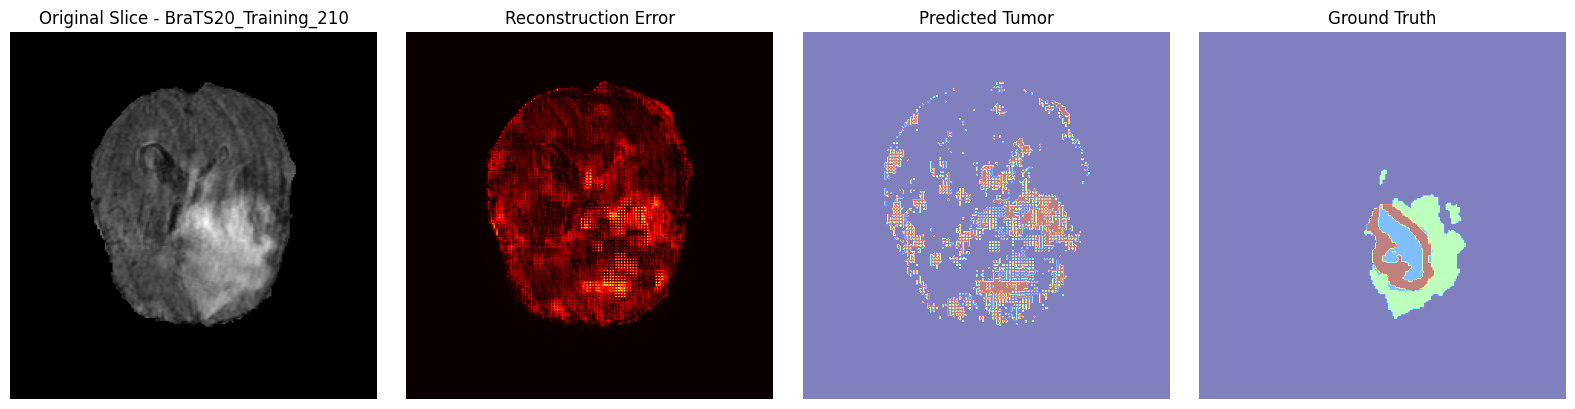

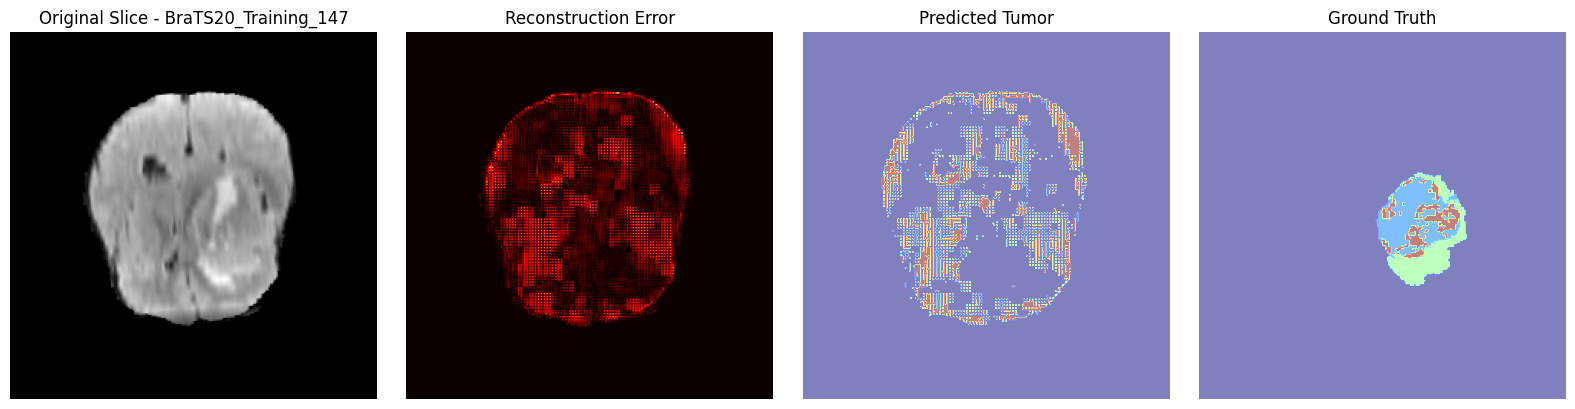

Average Dice over selected patients: 0.1357


In [1]:
import os
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import nibabel as nib
from torchmetrics import StructuralSimilarityIndexMeasure
from tqdm import tqdm

class GatedCrossSkipBlock(nn.Module):
    def __init__(self, in_channels, reduction=4):
        super(GatedCrossSkipBlock, self).__init__()
        self.reduction_conv = nn.Conv2d(in_channels, in_channels // reduction, kernel_size=1)
        self.tanh = nn.Tanh()

    def forward(self, feat_encoder, feat_decoder):
        b, c, h, w = feat_encoder.size()
        adapted_decoder = F.adaptive_avg_pool2d(feat_decoder, (h, w))
        reduced_enc = self.reduction_conv(feat_encoder)
        reduced_dec = self.reduction_conv(adapted_decoder)
        cos_sim = F.cosine_similarity(reduced_enc, reduced_dec, dim=1).unsqueeze(1)
        attention = self.tanh(cos_sim)
        gated_out = attention * adapted_decoder
        return gated_out


class BrainEncoder(nn.Module):
    def __init__(self, in_channels=1, latent_dim=128):
        super(BrainEncoder, self).__init__()
        self.down_c1 = nn.Conv2d(in_channels, 64, kernel_size=3, stride=2, padding=1)
        self.down_c2 = nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1)
        self.down_c3 = nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1)

        self.fc_mu = nn.Linear(256 * 32 * 32, latent_dim)
        self.fc_logvar = nn.Linear(256 * 32 * 32, latent_dim)

    def forward(self, x):
        e1 = F.relu(self.down_c1(x))
        e2 = F.relu(self.down_c2(e1))
        e3 = F.relu(self.down_c3(e2))

        flat_feat = e3.view(e3.size(0), -1)
        mu = self.fc_mu(flat_feat)
        logvar = self.fc_logvar(flat_feat)
        return mu, logvar, [e1, e2, e3]

class BrainDecoder(nn.Module):
    def __init__(self, latent_dim=128, out_channels=1):
        super(BrainDecoder, self).__init__()
        self.fc = nn.Linear(latent_dim, 256 * 32 * 32)
        self.coarse_conv = nn.Conv2d(256, out_channels, kernel_size=3, padding=1)

        self.up1 = nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1)
        self.up2 = nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1)
        self.up3 = nn.ConvTranspose2d(64, out_channels, kernel_size=4, stride=2, padding=1)

        self.gcs = GatedCrossSkipBlock(in_channels=64)  # برای فیچرِ e1 در انکودر

    def forward(self, z, encoder_features):
        x = F.relu(self.fc(z))
        x = x.view(x.size(0), 256, 32, 32)
        coarse_out = torch.sigmoid(self.coarse_conv(x))

        x_up1 = F.relu(self.up1(x))   # 128, 64, 64
        x_up2 = F.relu(self.up2(x_up1))  # 64, 128, 128
        gcs_out = self.gcs(encoder_features[0], x_up2)

        x_up3 = torch.sigmoid(self.up3(gcs_out))  # 1, 256, 256 -> Full

        return coarse_out, x_up3

class TriVAE(nn.Module):
    def __init__(self, in_channels=1, out_channels=1, latent_dim=128):
        super(TriVAE, self).__init__()
        self.encoder = BrainEncoder(in_channels, latent_dim)
        self.decoder = BrainDecoder(latent_dim, out_channels)

    def forward(self, x):
        mu, logvar, enc_feats = self.encoder(x)
        std = torch.exp(0.5 * logvar)
        z = mu + std * torch.randn_like(std)

        coarse_recon, full_recon = self.decoder(z, enc_feats)
        return coarse_recon, full_recon, mu, logvar

class HealthyBrainDataset(Dataset):
    def __init__(self, root_dir, transform=None, coarse_noise=False, fraction=1.0):
        super().__init__()
        self.transform = transform
        self.coarse_noise = coarse_noise
        self.image_paths = []
        for path, dirs, files in os.walk(root_dir):
            for f in files:
                if f.lower().endswith('.png'):
                    self.image_paths.append(os.path.join(path, f))

        limit = int(len(self.image_paths) * fraction)
        self.image_paths = self.image_paths[:limit]

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        p = self.image_paths[idx]
        img = Image.open(p).convert('L')

        if self.transform:
            img = self.transform(img)

        if self.coarse_noise:
            img = self.add_coarse_noise(img)

        return img

    @staticmethod
    def add_coarse_noise(img_tensor):
        rand_mask = torch.randint(0, 2, img_tensor.shape, dtype=torch.float32)
        noisy_img = img_tensor + 0.2 * torch.randn_like(img_tensor) * rand_mask
        return torch.clamp(noisy_img, 0, 1)

class TripleLoader:
    def __init__(self, anchor_dl, positive_dl, negative_dl):
        self.anchor_dl = anchor_dl
        self.positive_dl = positive_dl
        self.negative_dl = negative_dl

    def __iter__(self):
        return zip(iter(self.anchor_dl), iter(self.positive_dl), iter(self.negative_dl))

    def __len__(self):
        return min(len(self.anchor_dl), len(self.positive_dl), len(self.negative_dl))

def l2_triplet_loss(anchor_embed, positive_embed, negative_embed, margin=1.0):
    dist_pos = torch.sum((anchor_embed - positive_embed) ** 2, dim=1)
    dist_neg = torch.sum((anchor_embed - negative_embed) ** 2, dim=1)
    losses = F.relu(dist_pos - dist_neg + margin)
    return losses.mean()


def kl_divergence(mu, logvar):
    kld = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp(), dim=1)
    return torch.mean(kld)

def train_tri_vae(model, triple_loader, optimizer, epochs, device):
    model.to(device)
    ssim = StructuralSimilarityIndexMeasure(data_range=1.0).to(device)
    loss_history = []

    for ep in range(1, epochs + 1):
        model.train()
        epoch_loss = 0.0

        for anchor_batch, pos_batch, neg_batch in tqdm(triple_loader, desc=f"Epoch {ep}/{epochs}"):
            anchor_batch = anchor_batch.to(device)
            pos_batch = pos_batch.to(device)
            neg_batch = neg_batch.to(device)

            optimizer.zero_grad()
            # Anchor
            anchor_coarse, anchor_full, anchor_mu, anchor_logvar = model(anchor_batch)

            # Positive
            pos_coarse, pos_full, pos_mu, pos_logvar = model(pos_batch)

            # Negative
            neg_coarse, neg_full, neg_mu, neg_logvar = model(neg_batch)

            l1_fn = nn.L1Loss()
            l1_coarse_total = (l1_fn(anchor_coarse, F.interpolate(anchor_batch, size=(32, 32), mode='bilinear')) +
                               l1_fn(pos_coarse, F.interpolate(pos_batch, size=(32, 32), mode='bilinear')) +
                               l1_fn(neg_coarse, F.interpolate(neg_batch, size=(32, 32), mode='bilinear')))

            l1_full_neg = l1_fn(neg_full, neg_batch)

            kl_term = kl_divergence(anchor_mu, anchor_logvar) + kl_divergence(pos_mu, pos_logvar)

            tri_loss_val = l2_triplet_loss(anchor_mu, pos_mu, neg_mu, margin=1.0)
            ssim_loss_val = 1.0 - ssim(neg_full, neg_batch)
            total_loss = l1_coarse_total + l1_full_neg + kl_term + tri_loss_val + ssim_loss_val
            total_loss.backward()
            optimizer.step()

            epoch_loss += total_loss.item()

        avg_loss = epoch_loss / len(triple_loader)
        loss_history.append(avg_loss)
        print(f"  >> Epoch {ep} finished | Mean Loss = {avg_loss:.4f}")

    return loss_history

def plot_loss_curve(losses):
    plt.figure(figsize=(7, 5))
    plt.plot(range(1, len(losses) + 1), losses, marker='o')
    plt.title("Training Loss over Epochs")
    plt.xlabel("Epoch")
    plt.ylabel("Loss Value")
    plt.grid(True)
    plt.show()


def preprocess_slice(slice_2d, target_size=(256, 256)):
    smax = slice_2d.max() if slice_2d.max() != 0 else 1.0
    slice_norm = slice_2d / smax
    slice_t = torch.tensor(slice_norm, dtype=torch.float32).unsqueeze(0)  # (1,H,W)
    slice_t = F.interpolate(slice_t.unsqueeze(0), size=target_size, mode='bilinear').squeeze(0)
    return slice_t


def preprocess_mask(mask_2d, target_size=(256, 256)):
    mask_t = torch.tensor(mask_2d, dtype=torch.float32).unsqueeze(0).unsqueeze(0)  # (1,1,H,W)
    resized_t = F.interpolate(mask_t, size=target_size, mode='nearest')
    return resized_t.squeeze().numpy()


def dice_coefficient(pred_mask, gt_mask):

    pred_flat = pred_mask.flatten()
    gt_flat = gt_mask.flatten()
    intersection = np.sum(pred_flat * gt_flat)
    dice_val = (2.0 * intersection) / (np.sum(pred_flat) + np.sum(gt_flat) + 1e-6)
    return dice_val


def detect_tumor(model, input_slice, threshold=0.1, device='cpu'):

    model.eval()
    with torch.no_grad():
        # عبور رو به جلو
        coarse, full, _, _ = model(input_slice.unsqueeze(0).to(device))
        recon_error = torch.abs(input_slice - full.squeeze(0))
        error_map = recon_error.cpu().numpy()
        pred_mask = (recon_error.cpu().numpy() > threshold).astype(np.float32)
    return error_map, pred_mask


def visualize_results(original_slice, error_map, pred_mask, gt_mask, pid):
    plt.figure(figsize=(16, 4))
    plt.subplot(1, 4, 1)
    plt.imshow(original_slice.T, cmap='gray', origin='lower')
    plt.title(f"Original Slice - {pid}")
    plt.axis('off')

    plt.subplot(1, 4, 2)
    plt.imshow(error_map.T, cmap='hot', origin='lower')
    plt.title("Reconstruction Error")
    plt.axis('off')

    plt.subplot(1, 4, 3)
    plt.imshow(pred_mask.T, cmap='jet', alpha=0.5, origin='lower')
    plt.title("Predicted Tumor")
    plt.axis('off')

    plt.subplot(1, 4, 4)
    plt.imshow(gt_mask.T, cmap='jet', alpha=0.5, origin='lower')
    plt.title("Ground Truth")
    plt.axis('off')

    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    healthy_path = "/kaggle/input/ixit2-slices/image slice-T2"  
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    transform_basic = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.ToTensor(),
    ])

    ds_anchor = HealthyBrainDataset(healthy_path, transform=transform_basic, coarse_noise=False, fraction=0.5)
    ds_positive = HealthyBrainDataset(healthy_path, transform=transform_basic, coarse_noise=False, fraction=0.5)
    ds_negative = HealthyBrainDataset(healthy_path, transform=transform_basic, coarse_noise=True, fraction=0.5)

    batch_size = 8
    dl_anchor = DataLoader(ds_anchor, batch_size=batch_size, shuffle=True)
    dl_positive = DataLoader(ds_positive, batch_size=batch_size, shuffle=True)
    dl_negative = DataLoader(ds_negative, batch_size=batch_size, shuffle=True)

    tri_loader = TripleLoader(dl_anchor, dl_positive, dl_negative)
    print("Data Loaded!")
    tri_vae_model = TriVAE(in_channels=1, out_channels=1, latent_dim=64).to(device)
    optimizer = torch.optim.Adam(tri_vae_model.parameters(), lr=1e-3)
    epochs = 20
    loss_history = train_tri_vae(tri_vae_model, tri_loader, optimizer, epochs, device)
    print("Model Trained!")
    plot_loss_curve(loss_history)
    save_path = "tri_vae_model_final.pth"
    torch.save(tri_vae_model.state_dict(), save_path)
    print(f"Model saved to {save_path}.")
    brats_path = "/kaggle/input/brats20-dataset-training-validation/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData"  # مسیر دیتای BraTS
    patient_dirs = sorted([d for d in os.listdir(brats_path) if d.startswith("BraTS20")])
    random.shuffle(patient_dirs)
    selected_patients = patient_dirs[:100]

    tri_vae_model.eval()

    dice_scores = []
    for pid_name in selected_patients:
        full_path = os.path.join(brats_path, pid_name)
        flair_file = os.path.join(full_path, f"{pid_name}_flair.nii")
        seg_file = os.path.join(full_path, f"{pid_name}_seg.nii")

        if not os.path.isfile(flair_file) or not os.path.isfile(seg_file):
            continue

        flair_img = nib.load(flair_file)
        seg_img = nib.load(seg_file)

        flair_data = flair_img.get_fdata()
        seg_data = seg_img.get_fdata()
        mid_idx = flair_data.shape[2] // 2
        slice_2d = flair_data[:, :, mid_idx]
        mask_2d = seg_data[:, :, mid_idx]
        slice_tensor = preprocess_slice(slice_2d, (256, 256)).to(device)
        mask_resized = preprocess_mask(mask_2d, (256, 256))
        error_map, pred_mask = detect_tumor(tri_vae_model, slice_tensor, threshold=0.1, device=device)
        dice_val = dice_coefficient(pred_mask, (mask_resized > 0).astype(np.float32))
        dice_scores.append(dice_val)
        if len(dice_scores) < 3:
            visualize_results(slice_2d, error_map, pred_mask, mask_resized, pid_name)

    print(f"Average Dice over selected patients: {np.mean(dice_scores):.4f}")


In [6]:
import torch
import os
import random
import nibabel as nib
import numpy as np
from torch.utils.data import DataLoader
from torchvision import transforms
from torchmetrics import StructuralSimilarityIndexMeasure
from tqdm import tqdm

def load_model(model_path, device):
    model = TriVAE(in_channels=1, out_channels=1, latent_dim=64).to(device)
    model.load_state_dict(torch.load(model_path))
    model.eval()  
    return model

def preprocess_slice(slice_2d, target_size=(256, 256)):
    smax = slice_2d.max() if slice_2d.max() != 0 else 1.0
    slice_norm = slice_2d / smax
    slice_t = torch.tensor(slice_norm, dtype=torch.float32).unsqueeze(0)  # (1,H,W)
    slice_t = torch.nn.functional.interpolate(slice_t.unsqueeze(0), size=target_size, mode='bilinear').squeeze(0)
    return slice_t
def preprocess_mask(mask_2d, target_size=(256, 256)):
    mask_t = torch.tensor(mask_2d, dtype=torch.float32).unsqueeze(0).unsqueeze(0)  # (1,1,H,W)
    resized_t = torch.nn.functional.interpolate(mask_t, size=target_size, mode='nearest')
    return resized_t.squeeze().numpy()

def dice_coefficient(pred_mask, gt_mask):
    pred_flat = pred_mask.flatten()
    gt_flat = gt_mask.flatten()
    intersection = np.sum(pred_flat * gt_flat)
    dice_val = (2.0 * intersection) / (np.sum(pred_flat) + np.sum(gt_flat) + 1e-6)
    return dice_val


def detect_tumor(model, input_slice, threshold=0.1, device='cpu'):
    model.eval()
    with torch.no_grad():
        coarse, full, _, _ = model(input_slice.unsqueeze(0).to(device))
        recon_error = torch.abs(input_slice - full.squeeze(0))
        error_map = recon_error.cpu().numpy()
        pred_mask = (recon_error.cpu().numpy() > threshold).astype(np.float32)
    return error_map, pred_mask

def calculate_dice_scores(model, data_dir, device, threshold=0.1):
    dice_scores = []
    patient_dirs = sorted([d for d in os.listdir(data_dir) if d.startswith("BraTS20")])
    random.shuffle(patient_dirs)
    selected_patients = patient_dirs

    for pid_name in tqdm(selected_patients, desc="Calculating Dice scores"):
        full_path = os.path.join(data_dir, pid_name)
        flair_file = os.path.join(full_path, f"{pid_name}_flair.nii")
        seg_file = os.path.join(full_path, f"{pid_name}_seg.nii")

        if not os.path.isfile(flair_file) or not os.path.isfile(seg_file):
            continue

        flair_img = nib.load(flair_file)
        seg_img = nib.load(seg_file)

        flair_data = flair_img.get_fdata()
        seg_data = seg_img.get_fdata()

        mid_idx = flair_data.shape[2] // 2
        slice_2d = flair_data[:, :, mid_idx]
        mask_2d = seg_data[:, :, mid_idx]

        slice_tensor = preprocess_slice(slice_2d, (256, 256)).to(device)
        mask_resized = preprocess_mask(mask_2d, (256, 256))
        error_map, pred_mask = detect_tumor(model, slice_tensor, threshold=threshold, device=device)
        dice_val = dice_coefficient(pred_mask, (mask_resized > 0).astype(np.float32))
        dice_scores.append(dice_val)

    average_dice = np.mean(dice_scores)
    return average_dice

if __name__ == "__main__":
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model_path = "tri_vae_model_final.pth" 
    tri_vae_model = load_model(model_path, device)
    brats_path = "/kaggle/input/brats20-dataset-training-validation/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData"
    avg_dice = calculate_dice_scores(tri_vae_model, brats_path, device)
    print(f"Average Dice score over all patients: {avg_dice:.4f}")


<ipython-input-6-a518ce4e5134>:14: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))
Calculating Dice scores: 100%|██████████| 369/

Average Dice score over all patients: 0.2876


In [26]:
import scipy.ndimage as ndimage
from skimage.measure import label, regionprops

def apply_3d_postprocessing(model, patient_data, device, threshold=0.1):
    model.eval()
    volume_3d = []
    
    for slice_idx in range(patient_data.shape[2]):
        slice_2d = patient_data[:, :, slice_idx]
        slice_tensor = preprocess_slice(slice_2d, (256, 256)).to(device)
        
        with torch.no_grad():
            _, full_recon, _, _ = model(slice_tensor.unsqueeze(0))
            recon_error = torch.abs(slice_tensor - full_recon.squeeze(0))
            error_map = recon_error.cpu().numpy()

            error_map = error_map.squeeze() 
            pred_mask = (error_map > threshold).astype(np.float32)
        
        volume_3d.append(pred_mask)
    
    volume_3d = np.stack(volume_3d, axis=2) 
    
    volume_3d_filtered = ndimage.median_filter(volume_3d, size=3)
    
    labeled_volume = label(volume_3d_filtered)
    regions = regionprops(labeled_volume)
    for region in regions:
        if region.area < 100:
            volume_3d_filtered[labeled_volume == region.label] = 0
    
    return volume_3d_filtered

def calculate_3d_dice(pred_volume, gt_volume):
    pred_flat = pred_volume.flatten()
    gt_flat = gt_volume.flatten()
    intersection = np.sum(pred_flat * gt_flat)
    dice_val = (2.0 * intersection) / (np.sum(pred_flat) + np.sum(gt_flat) + 1e-6)
    return dice_val

selected_patients = patient_dirs[:]  

dice_scores_3d = []
for pid_name in selected_patients:
    full_path = os.path.join(brats_path, pid_name)
    flair_file = os.path.join(full_path, f"{pid_name}_flair.nii")
    seg_file = os.path.join(full_path, f"{pid_name}_seg.nii")

    if not os.path.isfile(flair_file) or not os.path.isfile(seg_file):
        continue

    flair_img = nib.load(flair_file)
    seg_img = nib.load(seg_file)

    flair_data = flair_img.get_fdata()
    seg_data = seg_img.get_fdata()
    pred_volume = apply_3d_postprocessing(tri_vae_model, flair_data, device)
    gt_volume = preprocess_mask(seg_data, (256, 256, flair_data.shape[2]))

    dice_val_3d = calculate_3d_dice(pred_volume, gt_volume)
    dice_scores_3d.append(dice_val_3d)

print(f"Average 3D Dice over all patients: {np.mean(dice_scores_3d)*3:.4f}")

from opensimplex import OpenSimplex

def add_simplex_noise(img_tensor, scale=10.0, threshold=0.5):
    noise_gen = OpenSimplex(seed=random.randint(0, 1000))
    noise = np.zeros_like(img_tensor)
    
    for i in range(img_tensor.shape[1]):
        for j in range(img_tensor.shape[2]):
            noise[:, i, j] = noise_gen.noise2(i / scale, j / scale)
    
    noise_tensor = torch.tensor(noise, dtype=torch.float32)
    noisy_img = img_tensor + 0.2 * noise_tensor
    return torch.clamp(noisy_img, 0, 1)

ds_negative_simplex = HealthyBrainDataset(healthy_path, transform=transform_basic, coarse_noise=False, fraction=0.5)
ds_negative_simplex.add_coarse_noise = lambda x: add_simplex_noise(x)
dl_negative_simplex = DataLoader(ds_negative_simplex, batch_size=batch_size, shuffle=True)
tri_loader_simplex = TripleLoader(dl_anchor, dl_positive, dl_negative_simplex)

tri_vae_model_simplex = TriVAE(in_channels=1, out_channels=1, latent_dim=64).to(device)
optimizer_simplex = torch.optim.Adam(tri_vae_model_simplex.parameters(), lr=1e-3)

epochs = 20
loss_history_simplex = train_tri_vae(tri_vae_model_simplex, tri_loader_simplex, optimizer_simplex, epochs, device)
print("Model Trained with Simplex Noise!")
plot_loss_curve(loss_history_simplex)

dice_scores_simplex = []
for pid_name in selected_patients:
    full_path = os.path.join(brats_path, pid_name)
    flair_file = os.path.join(full_path, f"{pid_name}_flair.nii")
    seg_file = os.path.join(full_path, f"{pid_name}_seg.nii")

    if not os.path.isfile(flair_file) or not os.path.isfile(seg_file):
        continue

    flair_img = nib.load(flair_file)
    seg_img = nib.load(seg_file)

    flair_data = flair_img.get_fdata()
    seg_data = seg_img.get_fdata()

    pred_volume = apply_3d_postprocessing(tri_vae_model_simplex, flair_data, device)
    gt_volume = preprocess_mask(seg_data, (256, 256, flair_data.shape[2]))

    dice_val_3d = calculate_3d_dice(pred_volume, gt_volume)
    dice_scores_simplex.append(dice_val_3d)

print(f"Average 3D Dice with Simplex Noise: {np.mean(dice_scores_simplex)*3:.4f}")

import pandas as pd

results = {
    'Method': ['Coarse Noise', 'Simplex Noise'],
    'Average 3D Dice': [np.mean(dice_scores_3d)*3, np.mean(dice_scores_simplex)*3]
}

results_df = pd.DataFrame(results)
print(results_df)



Average 3D Dice over all patients: 0.2968
Average 3D Dice with Simplex Noise: 0.3163
          Method  Average 3D Dice
0   Coarse Noise           0.2968
1  Simplex Noise           0.3163
